<center>
<img src="../../img/ods_stickers.jpg">
## Open Data Science course. Session № 2
</center>
Authors: Olga Daikhovskaya, Yury Kashnitsky. The material is distributed under [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). You are free to use the material for any non-commercial purposes, mentioning the original authors is mandatory.

# <center>Homework № 7.
## <center> Unupervised learning

In this task, we will look at how data dimensionality reduction and clustering methods work. At the same time, we'll practice solving classification task again.

We will work with the [Samsung Human Activity Recognition] (https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. Download the data from there. The data comes from the accelerometers and gyros of Samsung Galaxy S3 mobile phones ( you can find more info about the features using on the link above), the type of activity of a person with a phone in his pocket is also known - whether he walked, stood, lay, sat or walked up or down the stairs.

First we imagine that the type of activity is unknown to us, and we will try to cluster people purely on the basis of available features. Then we solve the problem of determining the type of physical activity precisely as a classification problem.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [3]:
X_train = np.loadtxt("/Users/jumia/mlcourse_dubai/jupyter_notebooks/Lecture07_unsupervised/UCI_HAR_Dataset/train/X_train.txt")
y_train = np.loadtxt("/Users/jumia/mlcourse_dubai/jupyter_notebooks/Lecture07_unsupervised/UCI_HAR_Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("/Users/jumia/mlcourse_dubai/jupyter_notebooks/Lecture07_unsupervised/UCI_HAR_Dataset/test/X_test.txt")
y_test = np.loadtxt("/Users/jumia/mlcourse_dubai/jupyter_notebooks/Lecture07_unsupervised/UCI_HAR_Dataset/test/y_test.txt").astype(int)

For clustering, we do not need a target vector, so we'll work with the combination of training and test samples. Merge * X_train * with * X_test *, and * y_train * with * y_test *.

In [4]:
# Your code here
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

Define the number of unique values of the labels of the target class.

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size

[These labels correspond to:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 WALKING           
- 2 WALKING_UPSTAIRS  
- 3 WALKING_DOWNSTAIRS
- 4 SITTING           
- 5 STANDING          
- 6 LAYING            
- 7 STAND_TO_SIT      
- 8 SIT_TO_STAND      
- 9 SIT_TO_LIE        
- 10 LIE_TO_SIT        
- 11 STAND_TO_LIE      
- 12 LIE_TO_STAND  

Scale the sample using `StandardScaler` with default parameters.

In [7]:
# Your code here
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Reduce the number of dimensions using PCA, leaving as many components as necessary to explain at least 90% of the variance of the original (scaled) data. Use the scaled sample and fix the random_state (RANDOM_STATE constant).

In [8]:
# Your code here
# iterate n_components until we reach explained variance >= 90
from sklearn.decomposition import PCA
i = 1
max_explained_variance = 0
while max_explained_variance < 0.9 :
    pca = PCA(n_components= i, random_state=RANDOM_STATE)
    pca.fit(X_scaled)
    max_explained_variance = max(np.cumsum(pca.explained_variance_ratio_))
    i += 1
else :
    X_pca =pca.transform(X_scaled)
    print(max_explained_variance)

0.9015056286454438


** Question 1: ** <br>
What is the minimum number of main components required to cover the 90% of the variance of the original (scaled) data?

In [9]:
# Your code here
# using the code above, we just need to get the i where the condition max_explained_variance >= 0.9 passed so i-1
print("the minimum number of main components required is",i-1)

the minimum number of main components required is 66


**Answer options:**
- 56 
- 65
- 66
- 193

**Вопрос 2:**<br>
What percentage of the variance is covered by the first main component? Round to the nearest percent.

**Answer options:**
- 45
- 51
- 56
- 61

In [10]:
# Your code here
print("the first main component explains (%):",round(pca.explained_variance_ratio_[0]*100))

the first main component explains (%): 51.0


Visualize the data in the projection on the first two main components.

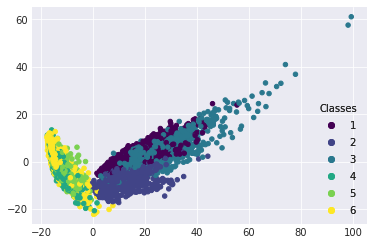

In [11]:
# Your code here
fig, ax = plt.subplots()
scatter = ax.scatter(X_pca[:,0] ,X_pca[:,1] , c=y, s=20, cmap='viridis');
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Classes")
ax.add_artist(legend1)

**Question 3:**<br>
If everything worked out correctly, you will see a number of clusters, almost perfectly separated from each other. What types of activity are included in these clusters? <br>

**Answer options:**
- 1 cluster: all 12 activities
- 2 clusters: 
- 3 clusters: 
- 5 clusters
- 12 clusters

In [12]:
print("we see 2 main clusters, first one with classes 1 WALKING 2 WALKING_UPSTAIRS 3 WALKING_DOWNSTAIRS \
and 2nd one with classes 4 SITTING 5 STANDING 6 LAYING")

we see 2 main clusters, first one with classes 1 WALKING 2 WALKING_UPSTAIRS 3 WALKING_DOWNSTAIRS and 2nd one with classes 4 SITTING 5 STANDING 6 LAYING


------------------------------

Run the data clustering using the `KMeans` method, training the model on data with a reduced PCA dimension. In this case, we will give a clue to look for exactly 6 clusters, but in general case we will not know how many clusters we should be searching.

Options:

- ** n_clusters ** = n_classes (number of unique labels of the target class)
- ** n_init ** = 100
- ** random_state ** = RANDOM_STATE (for the reproducibility of the result)

Other parameters should have default values.

In [13]:
# Your code here
# for training the model on data with a reduced PCA dimension, we take the X_pca instead of X
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters= 6 ,n_init = 100, random_state=RANDOM_STATE).fit(X_pca)

Visualize the data in the projection on the first two main components. Color the dots according to the clusters received.

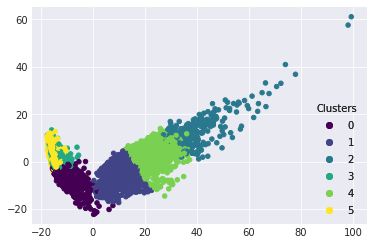

In [14]:
# Your code here
cluster_labels = kmeans.labels_
fig, ax = plt.subplots()
scatter = ax.scatter( X_pca[:,0] ,X_pca[:,1] , c=cluster_labels, s=20, cmap='viridis');
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Clusters")
ax.add_artist(legend1)

Look at the correspondence between the cluster marks and the original class labels and what kinds of activities the `KMeans` algorithm is confused at.

In [15]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['WALKING', 'WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDING','LAYING','All']
tab.columns = ['cluster' + str(i) for i in range(6)] + ['all']
tab

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,all
WALKING,0,904,78,0,740,0,1722
WALKING_UPSTAIRS,2,1241,5,0,296,0,1544
WALKING_DOWNSTAIRS,0,320,196,0,890,0,1406
SITTING,450,1,0,1234,0,92,1777
STANDING,562,0,0,1344,0,0,1906
LAYING,329,5,0,52,0,1558,1944
All,1343,2471,279,2630,1926,1650,10299


In [16]:
#calculate the metric that characterizes how easily the class separates from others when clustering
# take the max of each row and then divide by the row total ('all') 
data = pd.DataFrame(data=tab)
data.iloc[0:6,0:6].max(axis=1)

WALKING                904
WALKING_UPSTAIRS      1241
WALKING_DOWNSTAIRS     890
SITTING               1234
STANDING              1344
LAYING                1558
dtype: int64

In [17]:
data['all'].iloc[0:6]

WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
SITTING               1777
STANDING              1906
LAYING                1944
Name: all, dtype: int64

In [18]:
data.iloc[0:6,0:6].max(axis=1)/data['all'].iloc[0:6]

WALKING               0.524971
WALKING_UPSTAIRS      0.803756
WALKING_DOWNSTAIRS    0.633001
SITTING               0.694429
STANDING              0.705142
LAYING                0.801440
dtype: float64

We see that for each class (i.e., each activity) there are several clusters. Let's look at the maximum percentage of objects in a class that are assigned to a single cluster. This will be a simple metric that characterizes how easily the class separates from others when clustering.

Example: if for the class of "WALKING_UPSTAIRS", in which there are 1544 objects, the distribution of clusters is:
 - cluster 1 - 0
 - cluster 2 - 0
 - cluster 3 - 949
 -  ....
 - cluster 12 - 357
 
 then such a share will be 949/1544 $ \ approx $ 0.61.

** Question 4: ** <br>
Which activity has been separated from the rest better than others based on the simple metric described above? <br>

**Answer:**
- 1 WALKING           
- 2 WALKING_UPSTAIRS  
- 3 WALKING_DOWNSTAIRS
- 4 SITTING           
- 5 STANDING          
- 6 LAYING            
- 7 STAND_TO_SIT      
- 8 SIT_TO_STAND      
- 9 SIT_TO_LIE        
- 10 LIE_TO_SIT        
- 11 STAND_TO_LIE      
- 12 LIE_TO_STAND  
- there is no correct answer

In [19]:
#calculate the metric that characterizes how easily the class separates from others when clustering
# take the max of each row and then divide by the row total ('all') 
data = pd.DataFrame(data=tab)
data.iloc[0:6,0:6].max(axis=1)

WALKING                904
WALKING_UPSTAIRS      1241
WALKING_DOWNSTAIRS     890
SITTING               1234
STANDING              1344
LAYING                1558
dtype: int64

In [20]:
data['all'].iloc[0:6]

WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
SITTING               1777
STANDING              1906
LAYING                1944
Name: all, dtype: int64

In [21]:
data.iloc[0:6,0:6].max(axis=1)/data['all'].iloc[0:6]

WALKING               0.524971
WALKING_UPSTAIRS      0.803756
WALKING_DOWNSTAIRS    0.633001
SITTING               0.694429
STANDING              0.705142
LAYING                0.801440
dtype: float64

In [22]:
print( max(data.iloc[0:6,0:6].max(axis=1)/data['all'].iloc[0:6]))
print("so WALKING_UPSTAIRS activity has been separated from the rest better than others")

0.8037564766839378
so WALKING_UPSTAIRS activity has been separated from the rest better than others


Use the elbow method to select the optimal number of clusters. Parameters of the algorithm and the data we use are the same as before, we change only `n_clusters`.

In [23]:
# Your code here
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, random_state = RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


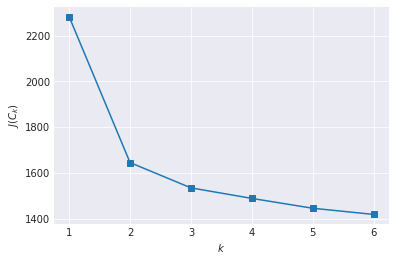

In [24]:
plt.plot(range(1, 7), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [25]:
print('optimal number of clusters is 2')

optimal number of clusters is 2




We calculate $ D(k) $, as described in the lecture

In [26]:
# Your code here
#D(k) = {|J(C_k) - J(C_{k+1})|} / {|J(C_{k-1}) - J(C_k)|}  

In [27]:
inertia

[2282.4808249103435,
 1644.6537398436428,
 1534.066764764732,
 1487.9728353684052,
 1444.9416142987234,
 1417.9039588967064]

In [28]:
def D (k,inertia) : 
    k = k-1
    print(abs(inertia[k] - inertia[k+1])/abs(inertia[k-1] - inertia[k]))


In [29]:
print(D(1,inertia),D(2,inertia),D(3,inertia),D(4,inertia),D(5,inertia))

0.7377332312944863
0.17338080753868623
0.41681155817342674
0.9335550610079031
0.6283264738928523
None None None None None


** Question 5: ** <br>
How many clusters can we choose according to the elbow method? <br>

**Answer options:**
- 1
- 2
- 3
- 4
- 5
- 6
- 7 

In [30]:
print("D(k) is minimal for k = 2")

D(k) is minimal for k = 2


------------------------

Let's try another method of clustering, which was described in the article - agglomerative clustering.

In [31]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

Calculate the Adjusted Rand Index (`sklearn.metrics`) for the resulting clustering and for ` KMeans` with the parameters from the 4th question.

In [32]:
# Your code here
from sklearn import metrics
algo = ag
print('Adjusted Rand Index of agglomerative clustering is:',metrics.adjusted_rand_score(y, algo.labels_))
    

Adjusted Rand Index of agglomerative clustering is: 0.49284557887865715


In [33]:
algo2 = KMeans(n_clusters= 2 ,n_init = 100, random_state=RANDOM_STATE).fit(X_pca)
print('Adjusted Rand Index of Kmean is:',metrics.adjusted_rand_score(y, algo2.labels_))

Adjusted Rand Index of Kmean is: 0.3296106738894193


** Question 6: ** <br>
Select all the correct statements. <br>

** Answer options: **
- ARI expresses the similarity of the tags obtained after clustering, with class labels for the same sample and the higher the value of this index, the better
- According to ARI, KMeans handled clustering worse than Agglomerative Clustering
- For ARI, it does not matter which tags are assigned to the cluster, only the partitioning of objects into clusters is important
- In case of random partitioning into clusters ARI will be close to zero



**Comment:**
Check ARI documentation in sklearn docs

In [34]:
print('the correct statement is the first one since according to scikit learn \
      The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.')

the correct statement is the first one since according to scikit learn       The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.


-------------------------------

You can notice that the task is not very well solved just as a clustering task if you select several clusters (> 2). Now, let's solve the classification problem, given that the data is marked up.

For classification, use the support vector machine - class `sklearn.svm.LinearSVC`. in this course, we did not review on this algorithm separately, but it is well-known and you can read about it, for example, in the materials of Yevgeny Sokolov - [here](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Choose the `C` hyperparameter for` LinearSVC` using `GridSearchCV`.

- Train the new `StandardScaler` on the training sample (with all the original features), apply scaling to the test sample
- In `GridSearchCV`, specify cv = 3.

In [35]:
# Your code here
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled =  scaler.transform(X_test)

In [84]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator = svc, param_grid = svc_params,cv=3, n_jobs=-1, verbose=True)

grid.fit(X_train_scaled, y_train)

grid.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   11.6s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   14.0s finished
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'C': 0.1}

In [85]:
# Your code here
best_svc = grid

In [94]:
best_svc.best_params_, best_svc.best_score_

({'C': 0.1}, 0.9382480957562568)

**Question 7**<br>
Which value of the hyperparameter `C` was chosen the best on the basis of cross-validation? <br>

**Answer options:**
- 0.001
- 0.01
- 0.1,
- 1
- 10

In [87]:
print('best value of c is:',best_svc.best_params_)

best value of c is: {'C': 0.1}


In [88]:
y_predicted = best_svc.predict(X_test_scaled)

In [89]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['WALKING', 'WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDING','LAYING','All']
tab.columns = ['WALKING', 'WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDING','LAYING','All']
tab

,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,LAYING,All
WALKING,494,2,0,0,0,0,496
WALKING_UPSTAIRS,12,459,0,0,0,0,471
WALKING_DOWNSTAIRS,2,4,413,1,0,0,420
SITTING,0,4,0,426,61,0,491
STANDING,0,0,0,15,517,0,532
LAYING,0,0,0,0,11,526,537
All,508,469,413,442,589,526,2947


As you can see, the classification problem is solved quite well.

** Question 8: ** <br>
Does SVM confuse the classes inside the activity groups we identified earlier (in the question 3)? We consider that it is confused, if the algorithm was wrong at least in one case. <br>

**Answer options:**
- yes
- no


In [91]:
print('yes SVM confuses, for instance STANDING contains 61 case from SITTING')

yes SVM confuses, for instance STANDING contains 61 case from SITTING


Finally, do the same thing as in Question 7, but add the PCA.

- Use the samples `X_train_scaled` and` X_test_scaled`
- Teach the same PCA as before, on a scaled training sample, apply the conversion to a test
- Choose the hyperparameter `C` with cross-validation on the training sample with PCA-transformation. You will notice how much faster it works than before.

** Question 9: ** <br>
What is the difference between the best quality (the proportion of correct answers) for cross-validation in the case of all 561 initial characteristics and in the second case, when the principal component method was applied? Round to the nearest percent. <br>

** Options: **
- The quality is the same
- 2%
- 4%
- 10%
- 20%

In [119]:
# Your code here
# let's apply the PCA of question 3
pca = PCA(n_components= 66, random_state=RANDOM_STATE)
pca.fit(X_train_scaled)

X_pca_train = pca.transform(X_train_scaled)
X_pca_test = pca.transform(X_test_scaled)

In [120]:
grid_pca = GridSearchCV(estimator = svc, param_grid = svc_params,cv=3, n_jobs=-1, verbose=True)
grid_pca.fit(X_pca_train, y_train)
grid_pca.best_params_, grid_pca.best_score_


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    2.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.0s finished
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


({'C': 0.1}, 0.9007072905331882)

In [121]:
print("the difference is:",round((grid.best_score_ - grid_pca.best_score_),2)*100,'% with a PCA on 66 components')
print("is reaches 42% with a PCI on 2 components")

the difference is: 4.0 % with a PCA on 66 components
is reaches 42% with a PCI on 2 components


** Question 10: ** <br>
Select all the correct statements:

** Answer options: **
- Principal component analysis in this case allowed to reduce the model training time, while the quality (the proportion of correct responses on cross-validation) suffered greatly, by more than 10%
- PCA can be used to visualize data, but there are better methods for this task, for example, tSNE. But PCA has less computational complexity
- PCA builds linear combinations of initial characteristics that are poorly interpreted by humans
- SVM works better than kMeans, since it clearly reduces the algorithm to the optimization problem

In [126]:
print("-1st statement is wrong since by increasing the number of components we can increase the quality while still reduicing the training time")
print("-2nd statement is correct: as stated in the course; with t-SNE, the picture looks better since PCA has a linear constraint while t-SNE does not. However, even with such a small dataset, the t-SNE algorithm takes significantly more time to complete than PCA.")
print("-3rd statement is wrong")
print("-4th statement is wrong")

-1st statement is wrong since by increasing the number of components we can increase the quality while still reduicing the training time
-2nd statement is correct: as stated in the course; with t-SNE, the picture looks better since PCA has a linear constraint while t-SNE does not. However, even with such a small dataset, the t-SNE algorithm takes significantly more time to complete than PCA.
-3rd statement is wrong
-4th statement is wrong
